## NNFL Assignment 1 (Fall '21)
You have been given a set of coloured images labeled either as "fire" or "not_fire". Your task to process this data as you see fit and create a model that will classify the unlabeled data present in the test folder.

In [ ]:
# Imports
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import seaborn as sns
import pandas as pd
import numpy as np
import keras
import os, random, shutil, cv2
from shutil import copyfile, copy
from keras import applications,activations
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input, SeparableConv2D
from keras.layers import Conv2D, Activation, MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [ ]:
print(tf. __version__)

2.6.0


In [ ]:
# Let's mount google drive into Colaboratory, so that data stored in drive can be used in Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Let's unzip the data that we have presently in zipped format in the below location, and store it somewhere

!unzip "/content/drive/MyDrive/nnfl-2021-assignment-1.zip" -d "/content/drive/MyDrive/Fire images dataset"

### Data Preprocessing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Fire images dataset/fire_videos/train.csv')
df.head()

,File,True_Label
0,1_2_0.jpg,fire
1,1_2_1.jpg,fire
2,1_2_2.jpg,fire
3,1_2_3.jpg,fire
4,1_2_4.jpg,fire


In [ ]:
df.info

<bound method DataFrame.info of                  File True_Label
0           1_2_0.jpg       fire
1           1_2_1.jpg       fire
2           1_2_2.jpg       fire
3           1_2_3.jpg       fire
4           1_2_4.jpg       fire
...               ...        ...
68942  66_127_246.jpg   not_fire
68943  66_127_247.jpg   not_fire
68944  66_127_248.jpg   not_fire
68945  66_127_249.jpg   not_fire
68946  66_127_250.jpg   not_fire

[68947 rows x 2 columns]>

In [ ]:
# create a group using groupby
group = df.groupby("True_Label")
  
# count the observations
group.count()

,File
True_Label,
fire,18215
not_fire,50732


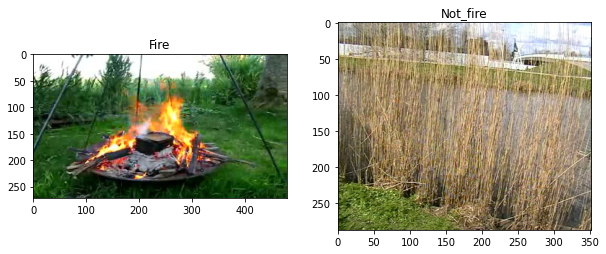

In [ ]:
# Sample figures...one of each fire and not_fire category

# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 2

# reading images
  
Image1 = mpimg.imread("/content/drive/MyDrive/Fire images dataset/NNFL Assignment/train/fire/64_62_12.jpg")
Image2 = mpimg.imread("/content/drive/MyDrive/Fire images dataset/NNFL Assignment/train/not_fire/66_127_237.jpg")

# Adds a subplot at the 1st position
ax1 = fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
ax1.title.set_text("Fire")
  
# Adds a subplot at the 2nd position
ax2 = fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
ax2.title.set_text("Not_fire")

In [ ]:
d = dict()
datasep = []
current = ''

for i in range(len(df)):
    a = df.loc[i, "File"]
    b = a.split('_')
    c = b[0]+'_'+b[1]

    if current != c:
      current = c
      datasep.append([])
      datasep[-1].append(a)
      
    else:
      datasep[-1].append(a)   

    d[c]=d.get(c,0)+1

print(d)                      # Contains video-wise frames...some videos have only 45 frames (minimum), while others have upto 5k frames

{'1_2': 102, '10_3': 120, '11_4': 120, '12_5': 280, '13_6': 90, '14_7': 90, '15_8': 90, '16_9': 150, '17_10': 255, '18_11': 90, '19_12': 242, '2_13': 167, '20_14': 221, '21_15': 259, '22_16': 60, '23_17': 198, '24_18': 198, '25_19': 89, '26_20': 163, '27_21': 88, '28_22': 90, '29_23': 94, '3_24': 109, '30_25': 57, '31_26': 60, '32_27': 147, '33_28': 103, '34_29': 393, '35_30': 287, '36_31': 128, '37_32': 134, '38_33': 296, '39_34': 120, '4_35': 150, '40_36': 121, '41_37': 330, '42_38': 120, '43_39': 140, '44_40': 439, '45_41': 260, '46_42': 246, '47_43': 208, '48_44': 1201, '49_45': 708, '5_46': 90, '50_47': 200, '51_48': 245, '52_49': 255, '53_50': 219, '54_51': 216, '55_52': 218, '56_53': 293, '57_54': 510, '58_55': 381, '59_56': 1655, '6_57': 120, '60_58': 2406, '61_59': 258, '62_60': 547, '63_61': 513, '64_62': 663, '65_63': 235, '66_64': 178, '1_65': 84, '10_66': 219, '11_67': 402, '12_68': 216, '13_69': 303, '14_70': 99, '15_71': 235, '16_72': 120, '17_73': 167, '18_74': 143, '19

In [ ]:
# datasep is a list of lists...essentially a list of video frames. Each list in datasep represents images from frames of a particular video
print(datasep)
print(len(datasep))                               # 126 videos present
print(np.array(datasep, dtype=object).shape)

In [ ]:
c1=0
c2=0
for i in datasep:
    x = df[df['File'] == i[0]]["True_Label"].values[0]    # Since each video is either "fire" or "not_fire", it suffices to check the first element of each entry in datasep
    if x=="fire":
        c1+=1
    
    elif x=="not_fire":
        c2+=1

print(c1, ' ', c2)

# To conclude, equal number of videos have "fire" and "not_fire". It is just that the videos having "not_fire" have too many frames, and hence the dataset as a whole has a lot many more images of not_fire as compared to fire.

63   63


In [ ]:
# Randomly take 45 images from each of the 126 types...so that we get 5670 images which can be divided later into train and validation in the ratio 70:30. A key additional benefit of doing this is that the distribution in resulting data would be perfectly balanced (50:50 for "fire" and "not_fire")

dataNew = []
for i in range(len(datasep)):
  random.shuffle(datasep[i])
  for data in datasep[i][:45]:
    dataNew.append(data)

print(dataNew)
print(len(dataNew))

In [ ]:
# Now, we need to store the file name (not the path) of each file in it's corresponding list
fire = []
not_fire = []

for i in dataNew:
    x = df[df['File'] == i]["True_Label"].values[0]     # Getting "True_Label" for file with given filename, and storing it in corresponding list
    if x=="fire":
        fire.append(i)
    
    elif x=="not_fire":
        not_fire.append(i)

In [ ]:
print(len(fire))
print(len(not_fire))

2835
2835


In [ ]:
# Randomly shuffling the images in each set and allocating roughly about 70 % to training set and remaining 30 % to validation set.
random.shuffle(fire)
random.shuffle(not_fire)

train_pos = fire[:2000]
train_neg = not_fire[:2000]

val_pos = fire[2000:]
val_neg = not_fire[2000:]

In [ ]:
# For deleting following directories (just in case)
# shutil.rmtree("/content/drive/MyDrive/Fire images dataset/NNFL Assignment/Train", ignore_errors=True)
# shutil.rmtree("/content/drive/MyDrive/Fire images dataset/NNFL Assignment/Val", ignore_errors=True)

In [ ]:
# Now, we need to create the proper directory structure. First we create 3 directories, "train", "val" and "test". Then, "train" & "val" will have further 2 directories each, by the names "fire" and "not_fire".

directory1 = "/content/drive/MyDrive/Fire images dataset/NNFL Assignment/train"
directory2 = "/content/drive/MyDrive/Fire images dataset/NNFL Assignment/val"
directory3 = "/content/drive/MyDrive/Fire images dataset/NNFL Assignment/test"

if not os.path.exists(directory1):
    os.mkdir(directory1)
  
if not os.path.exists(directory2):
    os.mkdir(directory2)

if not os.path.exists(directory3):
    os.mkdir(directory3)
  
os.mkdir("/content/drive/MyDrive/Fire images dataset/NNFL Assignment/train/fire")
os.mkdir("/content/drive/MyDrive/Fire images dataset/NNFL Assignment/train/not_fire")
os.mkdir("/content/drive/MyDrive/Fire images dataset/NNFL Assignment/val/fire")
os.mkdir("/content/drive/MyDrive/Fire images dataset/NNFL Assignment/val/not_fire")

In [ ]:
print(train_pos)
print(val_neg)
print('')
print(len(train_pos)+len(train_neg))
print(len(val_pos)+len(val_neg))

In [ ]:
# Saving the lists in numpy format, in case they are required again
np.save('/content/drive/MyDrive/Fire images dataset/NNFL Assignment/train_pos', train_pos)
np.save('/content/drive/MyDrive/Fire images dataset/NNFL Assignment/train_neg', train_neg)
np.save('/content/drive/MyDrive/Fire images dataset/NNFL Assignment/val_pos', val_pos)
np.save('/content/drive/MyDrive/Fire images dataset/NNFL Assignment/val_neg', val_neg)

In [ ]:
train_pos = np.load('/content/drive/MyDrive/Fire images dataset/NNFL Assignment/train_pos.npy')
train_neg = np.load('/content/drive/MyDrive/Fire images dataset/NNFL Assignment/train_neg.npy')

Finally, now that the directories have been created, we need to copy the required images from the original location (where they were stored after unzipping) to the new folders that we created just now.

In [ ]:
src = "/content/drive/MyDrive/Fire images dataset/fire_videos/train/"

for i in val_pos:
    if not os.path.exists('/content/drive/MyDrive/Fire images dataset/NNFL Assignment/val/fire/'+i):
        dst = "/content/drive/MyDrive/Fire images dataset/NNFL Assignment/val/fire"
        copy(src+i, dst)

for i in val_neg:
    if not os.path.exists('/content/drive/MyDrive/Fire images dataset/NNFL Assignment/val/not_fire/'+i):
        dst = "/content/drive/MyDrive/Fire images dataset/NNFL Assignment/val/not_fire"
        copy(src+i, dst)

for i in train_pos:
    if not os.path.exists('/content/drive/MyDrive/Fire images dataset/NNFL Assignment/train/fire/'+i):
        dst = "/content/drive/MyDrive/Fire images dataset/NNFL Assignment/train/fire"
        copy(src+i, dst)

for i in train_neg:
    if not os.path.exists('/content/drive/MyDrive/Fire images dataset/NNFL Assignment/train/not_fire/'+i):
        dst = "/content/drive/MyDrive/Fire images dataset/NNFL Assignment/train/not_fire"
        copy(src+i, dst)

In [ ]:
# Looping over the test folder, and copying the images to the test folder we created (just so that all folders at at the same place)

directory = "/content/drive/MyDrive/Fire images dataset/fire_videos/test"
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    copy(f, "/content/drive/MyDrive/Fire images dataset/NNFL Assignment/test")

In [ ]:
# This is just for testing to verify if all images have been copied to their respective folders

path, dirs, files = next(os.walk("/content/drive/MyDrive/Fire images dataset/NNFL Assignment/train/fire"))
print("Number of files in train/fire: ", len(files))

path, dirs, files = next(os.walk("/content/drive/MyDrive/Fire images dataset/NNFL Assignment/train/not_fire"))
print("Number of files in train/not_fire: ", len(files))

path, dirs, files = next(os.walk("/content/drive/MyDrive/Fire images dataset/NNFL Assignment/val/fire"))
print("Number of files in val/fire: ", len(files))

path, dirs, files = next(os.walk("/content/drive/MyDrive/Fire images dataset/NNFL Assignment/val/not_fire"))
print("Number of files in val/not_fire: ", len(files))

path, dirs, files = next(os.walk("/content/drive/MyDrive/Fire images dataset/NNFL Assignment/test"))
print("Number of files in test: ", len(files))

Number of files in train/fire:  2000
Number of files in train/not_fire:  2000
Number of files in val/fire:  835
Number of files in val/not_fire:  835
Number of files in test:  2820


In [ ]:
# Sample size of an image

print(cv2.imread("/content/drive/MyDrive/Fire images dataset/fire_videos/train/1_2_8.jpg").shape)
print(cv2.imread("/content/drive/MyDrive/Fire images dataset/NNFL Assignment/train/not_fire/32_90_3199.jpg").shape)

(1080, 1920, 3)
(576, 720, 3)


In [ ]:
# ImageDataGenerator generates batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).

train = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2)

validation = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2)

In [ ]:
# "flow_from_directory" takes the path to a directory & generates batches of augmented data. That's why creating those directories before was essential. Remember that the directory should contain 1 sub-directory per class. Since we have 2 classes here, each directory has 2 sub-directories.

train_dataset = train.flow_from_directory('/content/drive/MyDrive/Fire images dataset/NNFL Assignment/train', 
                                        target_size=(250,250),                    # size of input images, every image will be resized to this size.
                                        batch_size=128,                           # no. of images to be yielded from the generator per batch
                                        class_mode='categorical',
                                        shuffle=True)                             # shuffle the order of the images that is being yielded

validation_dataset = validation.flow_from_directory('/content/drive/MyDrive/Fire images dataset/NNFL Assignment/val', 
                                             target_size=(250,250),
                                             batch_size=128,
                                             class_mode='categorical',
                                             shuffle=True)

Found 4000 images belonging to 2 classes.
Found 1670 images belonging to 2 classes.


In [ ]:
print(len(train_dataset))
print(len(validation_dataset))
print(train_dataset.n)
print(validation_dataset.n)

32
14
4000
1670


In [ ]:
train_dataset.class_indices

{'fire': 0, 'not_fire': 1}

### Model Architecture and Training
This model is the one that fetched us a result of 95.319 % on the private leaderboard (1st position).

In [ ]:
model = Sequential()

model.add(Conv2D(64,(3,3), activation='relu', input_shape=(250,250,3)))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

# model.add(Conv2D(64,(3,3), activation='relu'))
# model.add(MaxPooling2D(2,2))
# model.add(BatchNormalization())

# model.add(Conv2D(128,(3,3), activation='relu'))
# model.add(MaxPooling2D(2,2))
# model.add(BatchNormalization())

model.add(Flatten())

# model.add(Dense(128, kernel_initializer='he_uniform', activation='relu'))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())

# model.add(Dense(64, kernel_initializer='he_uniform', activation='relu'))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())

model.add(Dense(24, kernel_initializer='he_uniform', activation='relu'))
model.add(BatchNormalization())

model.add(Dense(2, kernel_initializer='he_uniform', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 248, 248, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 124, 124, 64)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 124, 124, 64)      256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 984064)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                23617560  
_________________________________________________________________
batch_normalization_5 (Batch (None, 24)                96        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

In [ ]:
# Compiling the neural network

opt = tf.keras.optimizers.Adam(learning_rate=0.003)

model.compile(optimizer = opt, loss='categorical_crossentropy', metrics =['accuracy'])

In [ ]:
model_fit = model.fit(train_dataset,
                      steps_per_epoch=train_dataset.n // train_dataset.batch_size,        
                      epochs=30,
                      validation_data=validation_dataset,
                      validation_steps=validation_dataset.n // validation_dataset.batch_size)

Epoch 1/30
31/31 [==============================] - 3759s 122s/step - loss: 0.8477 - accuracy: 0.7358 - val_loss: 0.6275 - val_accuracy: 0.6520
Epoch 2/30
31/31 [==============================] - 151s 5s/step - loss: 0.3214 - accuracy: 0.8595 - val_loss: 0.5917 - val_accuracy: 0.6857
Epoch 3/30
31/31 [==============================] - 146s 5s/step - loss: 0.2660 - accuracy: 0.8897 - val_loss: 0.6054 - val_accuracy: 0.6611
Epoch 4/30
31/31 [==============================] - 150s 5s/step - loss: 0.2112 - accuracy: 0.9197 - val_loss: 0.6427 - val_accuracy: 0.6587
Epoch 5/30
31/31 [==============================] - 149s 5s/step - loss: 0.1698 - accuracy: 0.9421 - val_loss: 0.7447 - val_accuracy: 0.5595
Epoch 6/30
31/31 [==============================] - 149s 5s/step - loss: 0.1519 - accuracy: 0.9460 - val_loss: 0.7789 - val_accuracy: 0.5901
Epoch 7/30
31/31 [==============================] - 146s 5s/step - loss: 0.1334 - accuracy: 0.9517 - val_loss: 0.8752 - val_accuracy: 0.5427
Epoch 8/30

In [ ]:
model.save('/content/drive/MyDrive/Fire images dataset/NNFL Assignment/model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fire images dataset/NNFL Assignment/model/assets


In [ ]:
# Model that gave the best result on private leaderboard
model = tf.keras.models.load_model('/content/drive/MyDrive/Fire images dataset/NNFL Assignment/model')
model.summary()   

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 248, 248, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 124, 124, 64)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 124, 124, 64)      256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 984064)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                23617560  
_________________________________________________________________
batch_normalization_5 (Batch (None, 24)                96        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

### Post training Analysis

#### Graph plotting

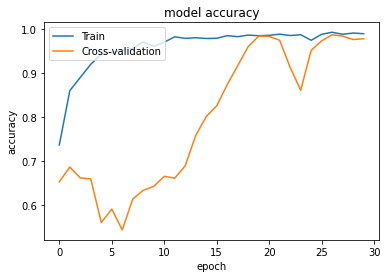

In [ ]:
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-validation'], loc='upper left')
plt.show()

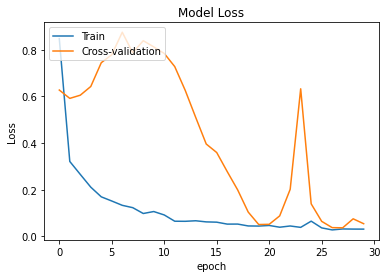

In [ ]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-validation'], loc='upper left')
plt.show()

#### Confusion Matrix plotting

In [ ]:
validation = ImageDataGenerator(rescale=1./255)   # No augmentation in validation data this time

validation_dataset = validation.flow_from_directory('/content/drive/MyDrive/Fire images dataset/NNFL Assignment/val', 
                                             target_size=(250,250),
                                             batch_size=1,                
                                             class_mode='categorical',
                                             shuffle=False)

# Note that this time, we have a batch size of 1 since we want each image to be taken into consideration exactly once. Also, shuffle is kept to false, so that the one to one correspondence to the classes of validation dataset can be used

Found 1670 images belonging to 2 classes.


In [ ]:
print(validation_dataset.classes)

[0 0 0 ... 1 1 1]


In [ ]:
predict = model.predict_generator(validation_dataset)
y_classes = predict.argmax(axis=-1) 

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[0.9988024  0.0011976 ]
 [0.03353293 0.96646707]] 



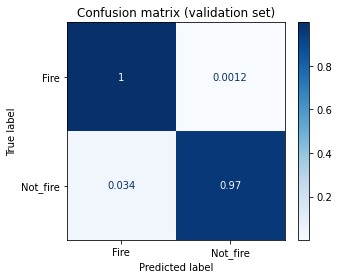

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = confusion_matrix(validation_dataset.classes, y_classes, normalize='true')
print(matrix, '\n')

display_labels = ['Fire','Not_fire']
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=display_labels)

fig, ax = plt.subplots(figsize=(5, 4))
disp = disp.plot(include_values=True, cmap=plt.cm.Blues, ax=ax, xticks_rotation='horizontal')
plt.title("Confusion matrix (validation set)")
plt.show()

### Testing and making predictions

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Fire images dataset/fire_videos/test.csv')
df_sample_sub = pd.read_csv('/content/drive/MyDrive/Fire images dataset/Sample Submission.csv')

In [ ]:
df_test.head()

,File
0,9_8_7.jpg
1,9_15_145.jpg
2,67_9_602.jpg
3,68_3_252.jpg
4,67_9_659.jpg


In [ ]:
df_test.info

<bound method DataFrame.info of               File
0        9_8_7.jpg
1     9_15_145.jpg
2     67_9_602.jpg
3     68_3_252.jpg
4     67_9_659.jpg
...            ...
2815  67_9_497.jpg
2816  70_13_48.jpg
2817  67_9_731.jpg
2818  7_12_194.jpg
2819  67_9_303.jpg

[2820 rows x 1 columns]>

In [ ]:
df_sample_sub.head()

,File,Label
0,9_8_7.jpg,fire
1,9_15_145.jpg,not_fire
2,67_9_602.jpg,fire
3,68_3_252.jpg,not_fire
4,67_9_659.jpg,fire


In [ ]:
test = ImageDataGenerator(        # No augmentation should be done on testing images, only rescaling as it had been done on training and validation sets
    rescale=1./255)

test_dataset = test.flow_from_directory('/content/drive/MyDrive/Fire images dataset/NNFL Assignment', 
                                    target_size=(250,250),
                                    batch_size=1,     # Need to sample each test image exactly once (that too without augmentation)
                                    class_mode=None,
                                    shuffle=False,    # to maintain a correlation between the file and the associated prediction (images are fetched lexicographically name-wise)
                                    classes=['test'])

Found 2820 images belonging to 1 classes.


In [ ]:
predict = model.predict_generator(test_dataset)
y_classes = predict.argmax(axis=-1)                   # predict the class label

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
print(predict)

[[9.9997365e-01 2.6385409e-05]
 [9.9996734e-01 3.2624204e-05]
 [9.9996877e-01 3.1213342e-05]
 ...
 [9.8431867e-01 1.5681274e-02]
 [9.8353344e-01 1.6466498e-02]
 [9.8342210e-01 1.6577886e-02]]


In [ ]:
# Let's see how many images have been predicted as fire and how many as not_fire in the test set.
fire_pred=0
not_fire_pred=0

for i in y_classes:
  if i==0:
      fire_pred+=1
  
  else:
      not_fire_pred+=1

print(fire_pred,' ',not_fire_pred)      

592   2228


In [ ]:
# Storing names of files in the test dataset
file_names = []
for file in test_dataset.filenames:
    file_names.append(file)

print(len(file_names))
print(file_names)

In [ ]:
# Extracting just the actual file name
file_names_refined = [i[5:] for i in file_names]
print(file_names_refined)

In [ ]:
labels = []
for i in range(len(file_names_refined)):
    if y_classes[i]==0:
        labels.append('fire')

    else:
        labels.append('not_fire')

In [ ]:
df_submit = pd.DataFrame()
df_submit['File'] = file_names_refined
df_submit['Label'] = labels
df_submit.head()

,File,Label
0,67_2_0.jpg,fire
1,67_2_1.jpg,fire
2,67_2_10.jpg,fire
3,67_2_11.jpg,fire
4,67_2_12.jpg,fire


In [ ]:
# Saving the dataframe to a CSV file, so that it can be uploaded on Kaggle
df_submit.to_csv('/content/drive/MyDrive/Fire images dataset/NNFL Assignment/baseline.csv', index=False)